# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Neural Network

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1./np.sqrt(fan_in)
    return (-lim,lim)

#Actor Neural Network
class Actor(nn.Module):
    
    def __init__(self,input_size,output_size, random_seed = 0, fc1_units = 256, fc2_units = 256):
        super(Actor,self).__init__()
        self.seed = torch.manual_seed(random_seed)
        self.fc1 = nn.Linear(input_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,output_size)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e3,3e3)
        
    def forward(self,state):
        a = F.relu(self.fc1(state))
        a = F.relu(self.fc2(a))
        a = F.tanh(self.fc3(a))
        return a
    

#Critics Neural Network
class Critic(nn.Module):
    
    def __init__(self,state_size,action_size, random_seed = 0, fc1_units = 256, fc2_units = 256):
        super(Critic,self).__init__()
        self.seed = torch.manual_seed(random_seed)
        self.fc1 = nn.Linear(state_size + action_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e3,3e3)
        
    def forward(self,state, action):
        a = torch.cat((state, action), dim=1)
        a = F.leaky_relu(self.fc1(a))
        a = F.leaky_relu(self.fc2(a))
        a = self.fc3(a)
        return a
        
    

In [7]:
class Hyperparams():
    """All Hyperparameters values are defined in one object for cluttering of multiple variables"""
    def __init__(self,num_agents, action_size, state_size,random_seed = 0, 
                 lr_actor = 1e-4, lr_critic=1e-4, tau = 1e-3, gamma = 0.99, 
                 weight_decay = 0,batch_size = 256, buffer_size = int(1e5)):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.num_agents = num_agents
        self.action_size = action_size
        self.state_size = state_size
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.random_seed = random_seed
        self.tau = tau
        self.gamma = gamma
        self.weight_decay = weight_decay
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        

In [8]:
import random
import copy
from collections import namedtuple,deque

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class OUNoise():
    
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * (np.random.rand(*x.shape)-0.5)
        self.state = x + dx
        return self.state

    
class ReplaceBuffer():
    
    def __init__(self,hyperparams):
        """Initialize a ReplayBuffer object."""
        self.hyperparams = hyperparams
        self.memory = deque(maxlen = hyperparams.buffer_size)
        self.experience = namedtuple("Experiences", field_names = ["state", "action", "reward","next_state", "done"])
        self.seed = random.seed(hyperparams.random_seed)
    
    def add(self,state,action,reward,next_state,done):
        """Adding Each Experience in Replay Buffer"""
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)
    
    def sample(self):
        """Sampling the stored Memory og size == batch size"""
        device = self.hyperparams.device
        num_agents = self.hyperparams.num_agents
        experiences = random.sample(self.memory, k =  self.hyperparams.batch_size)
        
        states = [torch.from_numpy(np.vstack([e.state[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions = [torch.from_numpy(np.vstack([e.action[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states = [torch.from_numpy(np.vstack([e.next_state[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]          
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)      
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)
    

class Agent():
    """Interacts with and learn from evironment"""
    
    def __init__(self, hyperparams, memory,index):
        """Initialize an Agent object"""
        self.hyperparams = hyperparams
    
        self.actor_local = Actor(hyperparams.state_size,
                                 hyperparams.action_size, 
                                 hyperparams.random_seed).to(hyperparams.device)
        self.actor_target = Actor(hyperparams.state_size,
                                  hyperparams.action_size,
                                  hyperparams.random_seed).to(hyperparams.device)
        
        self.critic_local = Critic(hyperparams.num_agents * hyperparams.state_size,
                                   hyperparams.num_agents * hyperparams.action_size, 
                                   hyperparams.random_seed).to(hyperparams.device)
        self.critic_target = Critic(hyperparams.num_agents * hyperparams.state_size,
                                   hyperparams.num_agents * hyperparams.action_size, 
                                   hyperparams.random_seed).to(hyperparams.device)
        
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),
                                          lr = hyperparams.lr_actor)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),lr = hyperparams.lr_critic, 
                                           weight_decay = hyperparams.weight_decay)
        
        self.hard_weight_copy(self.actor_target,self.actor_local)
        self.hard_weight_copy(self.critic_target,self.critic_local)
        
        self.noise = OUNoise(hyperparams.action_size, hyperparams.random_seed)
        self.memory = memory
        self.index = index
        
        
    def hard_weight_copy(self,target, source):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
            
    def step(self):
        "Save experience and use random sample from buffer to learn"
        if(len(self.memory) > self.hyperparams.batch_size):
            experiences = self.memory.sample()
            self.learn(experiences)
            
    def act(self,state,add_noise=True):
        "Returns actions for given state as per current policy"            
        state =  torch.from_numpy(state).float().to(self.hyperparams.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
    
    def learn(self,experiences):
        """Update policy and value parameters using given batch of experience tuples"""
        states, actions, rewards, next_states, dones = experiences
        
        states_tensor = torch.cat(states, dim=1).to(self.hyperparams.device)
        actions_tensor = torch.cat(actions, dim=1).to(self.hyperparams.device)
        next_states_tensor = torch.cat(next_states, dim=1).to(self.hyperparams.device)
        
        #--------------CRITIC LEARNING-----------
        next_actions = actions
        next_actions[self.index] = self.actor_target(next_states[self.index])
        #next_actions = [action.detach() for i, action in enumerate(next_actions)  if i != self.index ]
        next_actions_tensor = torch.cat(next_actions, dim=1).to(self.hyperparams.device)
        Q_target_next = self.critic_target(next_states_tensor, next_actions_tensor)
        Q_target = rewards + (self.hyperparams.gamma * Q_target_next * (1 - dones))
        Q_exp = self.critic_local(states_tensor,actions_tensor)
        critic_loss = F.mse_loss(Q_exp,Q_target)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        #-------------ACTOR_LEARNING--------------
        actor_pred = actions
        actor_pred[self.index] = self.actor_local(states[self.index])
        #actor_pred = [self.actor_local(state) for state in states]
        actor_pred_tensor = torch.cat(actor_pred, dim=1).to(self.hyperparams.device)
        actor_loss = -self.critic_local(states_tensor,actor_pred_tensor).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        #----------SOFT UPDATE-------------
        self.soft_update(self.critic_local,self.critic_target)
        self.soft_update(self.actor_local,self.actor_target)
    
    def soft_update(self,local_model,target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.hyperparams.tau*local_param.data + (1.0-self.hyperparams.tau)*target_param.data)


In [9]:
class Multi_Agent():
    """This class is actinag as adapter between main class and single agent to do MADDPG"""
    
    def __init__(self, hyperparams):
        """Initialize and create n agents"""
        
        self.hyperparams = hyperparams
        self.memory = ReplaceBuffer(hyperparams)
        self.agents = [Agent(hyperparams,self.memory,x) for x in range(hyperparams.num_agents)]  
        
    def step(self,states,actions,rewards,next_states,dones):
        "Save experience and use random sample from buffer to learn for each agents"
        for index,agent in enumerate(self.agents):
            self.memory.add(states,actions,rewards[index],next_states,dones[index])
            agent.step()

    def act(self,states):
        "Returns actions of multiple agents for agents states as per current policy"
        actions = np.zeros([hyperparams.num_agents, hyperparams.action_size])
        for index, agent in enumerate(self.agents):
            actions[index, :] = agent.act(states[index], add_noise = True)
        return actions

    def reset(self):
        """Reset Noide of every agent"""
        for agent in self.agents:
            agent.reset()
            

    def save(self):
        """Save Weights of every agent"""
        for agent_no in range(self.num_agents):
            torch.save(agents[agent_no].actor_local.state_dict(), 'checkpoint_actor_'+str(agent_no)+ '.pth')
            torch.save(agents[agent_no].critic_local.state_dict(),'checkpoint_critic_'+str(agent_no)+ '.pth') 

In [12]:
def mddpg(env,brain_name,multi_agent,num_agents, n_episodes=30, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    ep_05 = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        multi_agent.reset()
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = multi_agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            multi_agent.step(states,actions,rewards,next_states,dones)
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        max_scores = np.max(scores)       
        scores_deque.append(max_scores)
        scores_list.append(max_scores)
        average_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.10f}'.format(i_episode, average_score), end="")
        if(average_score >=  0.5):
            ep_05 +=1
            if(ep_05 >=100):
                multi_agent.save()
                break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.10f}'.format(i_episode, average_score))
    
    return scores_list

rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, -0.009999999776482582]
Episode 1	Average Score: 0.0000000000rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, -0.009999999776482582]
Episode 2	Average Score: 0.0000000000rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0, 0.0]
rewards==========[0.0,

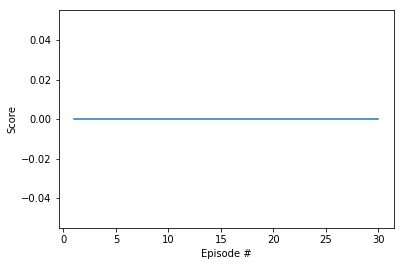

In [13]:
import matplotlib.pyplot as plt

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 1e-3
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0
random_seed = 0

hyperparams = Hyperparams(num_agents, action_size, state_size,random_seed, 
                 LR_ACTOR, LR_CRITIC, TAU, GAMMA, 
                 WEIGHT_DECAY,BATCH_SIZE, BUFFER_SIZE)

multi_agent = Multi_Agent(hyperparams)
        
scores = mddpg(env,brain_name,multi_agent, num_agents)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()